In [2]:
#importing the required stuff
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import csv
import yfinance as yf
import pandas_datareader.data as web


In [3]:
%matplotlib inline

In [4]:
# set number of assets (= number of qubits)
num_assets = 10
seed = 1234


start = datetime.datetime(2011, 1, 1)
end = datetime.datetime(2015, 12, 1)

df = web.DataReader(["JPM", "GS", "MSFT", "AAPL", "CO", "WMT", "DIS", "BA", "MCD", "NKE"],'yahoo', start, end)
df.to_csv(r'C:\Users\shrey\Documents\stockdata1.csv')
print (df)

# Using data from yahoo finance
# use the name listed for particular company that you wish to add
data = YahooDataProvider(
        tickers= ["JPM", "GS", "MSFT", "AAPL", "CO", "WMT", "DIS", "BA", "MCD", "NKE"],
        start=datetime.datetime(2015, 1, 1),
        end=datetime.datetime(2021, 12, 1),
    )

data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

Attributes  Adj Close                                                         \
Symbols           JPM          GS       MSFT       AAPL        CO        WMT   
Date                                                                           
2010-12-31  30.822556  139.064865  21.863102   9.836147  3.980296  41.184040   
2011-01-03  31.665421  143.108826  21.917925  10.049906  3.762469  41.665142   
2011-01-04  32.123699  143.133667  22.004093  10.102358  3.465432  41.825512   
2011-01-05  32.516506  143.894485  21.933594  10.184995  3.613951  41.550594   
2011-01-06  32.356480  142.414154  22.575933  10.176763  3.594148  41.206944   
...               ...         ...        ...        ...       ...        ...   
2015-11-24  55.353779  166.308701  48.774662  27.253246  6.316988  51.565166   
2015-11-25  55.420105  166.731812  48.271172  27.058388  6.257580  51.840565   
2015-11-27  55.677048  167.895370  48.486961  27.007948  6.316988  51.539349   
2015-11-30  55.270893  168.072296  48.86

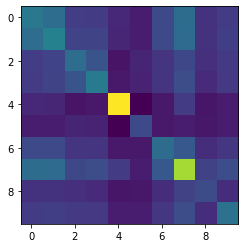

In [5]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()


In [6]:
q = 0.5  # set risk factor
budget = num_assets // 10 # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.00016030477245454906*x_0^2 + 0.00028680395382070..., 10 variables, 1 constraints, 'Portfolio optimization'>

In [7]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result,fname):
    
    f = open(fname, 'w')
    header = ['SELECTION', 'VALUE', 'PROBABLITY']
    writer = csv.writer(f)
    writer.writerow(header)
    
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        row = [x, value, probability]
        writer.writerow(row)
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))
    f.close()

In [8]:
#classical reference solution
#provide fname ='complete address/location of your .csv file'


exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)
fname = (r'C:\Users\shrey\Documents\stockdata1.csv') #change the location and nsame of .csv file

print_result(result,fname)

Optimal: selection [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], value -0.0012

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 0 0 0 0 0 0 0]	-0.0012		1.0000
[1 1 1 1 1 1 1 1 1 1]	82.2358		0.0000
[0 0 0 0 1 0 1 0 1 0]	4.0604		0.0000
[1 0 1 1 1 0 1 0 1 0]	25.3793		0.0000
[0 0 1 1 1 0 1 0 1 0]	16.2419		0.0000
[1 1 0 1 1 0 1 0 1 0]	25.3802		0.0000
[0 1 0 1 1 0 1 0 1 0]	16.2427		0.0000
[1 0 0 1 1 0 1 0 1 0]	16.2425		0.0000
[0 0 0 1 1 0 1 0 1 0]	9.1358		0.0000
[1 1 1 0 1 0 1 0 1 0]	25.3801		0.0000
[0 1 1 0 1 0 1 0 1 0]	16.2426		0.0000
[1 0 1 0 1 0 1 0 1 0]	16.2424		0.0000
[0 0 1 0 1 0 1 0 1 0]	9.1357		0.0000
[1 1 0 0 1 0 1 0 1 0]	16.2434		0.0000
[0 1 0 0 1 0 1 0 1 0]	9.1366		0.0000
[1 0 0 0 1 0 1 0 1 0]	9.1364		0.0000
[1 1 1 1 0 0 1 0 1 0]	25.3794		0.0000
[1 1 1 1 1 0 1 0 1 0]	36.5477		0.0000
[0 1 1 1 0 0 1 0 1 0]	16.2418		0.0000
[1 0 1 1 0 0 1 0 1 0]	16.2416		0.0000
[0 0 1 1 0 0 1 0 1 0]	9.1349		0.0000
[1 1 0 1

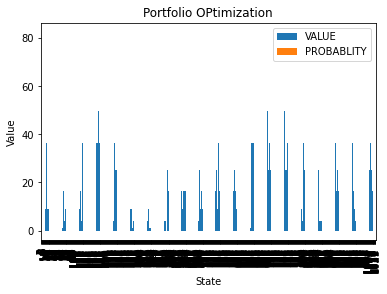

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\shrey\Documents\stockdata1.csv')

#df.plot(kind = 'bar', x = 'SELECTION', y = 'VALUE')

df.plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Value')
plt.title('Portfolio OPtimization')
plt.legend()
plt.show()


In [10]:
# VQE solution
#provide fname ='complete address/location of your .csv file'


from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

fname = (r'C:\Users\shrey\Documents\stockdata1.1.csv') #change the location and name of .csv file
print_result(result, fname)


c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit_optimization\algorithms\optimization_algorithm.py:138: UserWarning: The sum of probability of samples is not close to 1: f{sum_prob}
  warn("The sum of probability of samples is not close to 1: f{sum_prob}")


Optimal: selection [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], value -0.0012

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 0 0 0 0 0 0]	-0.0005		0.5653
[0 0 0 0 0 0 1 0 0 0]	-0.0003		0.4306
[1 0 0 0 0 0 0 0 0 0]	-0.0006		0.0006
[0 1 0 0 0 0 0 0 1 0]	1.0143		0.0005
[0 1 1 0 0 0 0 0 0 0]	1.0138		0.0004
[0 1 0 0 0 0 0 1 0 0]	1.0148		0.0004
[0 1 0 0 0 0 1 0 0 0]	1.0147		0.0004
[0 0 1 0 0 0 1 0 0 0]	1.0139		0.0002
[0 0 0 1 0 0 1 0 0 0]	1.0140		0.0002
[0 1 0 0 0 1 0 0 0 0]	1.0145		0.0001
[1 1 0 0 0 0 1 0 0 0]	4.0603		0.0001
[0 0 0 0 0 0 1 1 0 0]	1.0149		0.0001
[1 1 0 0 0 0 0 0 0 0]	1.0144		0.0001
[0 0 0 0 0 1 0 0 1 0]	1.0143		0.0001
[0 1 0 0 0 0 1 0 1 0]	4.0600		0.0001
[1 0 0 0 0 0 0 0 1 0]	1.0141		0.0001
[0 0 0 1 0 0 0 0 1 0]	1.0136		0.0001
[0 0 0 0 0 0 0 0 0 0]	1.0153		0.0001
[0 0 0 0 0 0 1 0 0 1]	1.0143		0.0000
[0 0 0 0 0 0 1 0 1 0]	1.0144		0.0000
[0 0 0 0 0 0 0 1 1 0]	1.0144		0.0000
[0 0 0 0 0 1 0 0 0 0

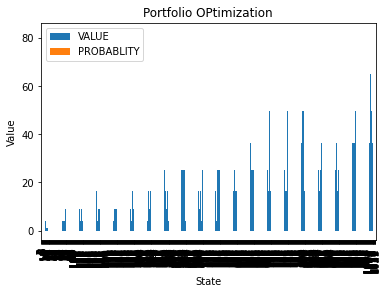

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\shrey\Documents\stockdata1.1.csv')

df.plot(kind = 'bar')
plt.xlabel('State')
plt.ylabel('Value')
plt.title('Portfolio OPtimization')
plt.legend()
plt.show()


In [12]:
# QAOA solution
#provide fname ='complete address/location of your .csv file'


algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

fname = (r'C:\Users\shrey\Documents\stockdata1.2.csv') #change the location and name of .csv file
print_result(result, fname)


c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit_optimization\algorithms\optimization_algorithm.py:138: UserWarning: The sum of probability of samples is not close to 1: f{sum_prob}
  warn("The sum of probability of samples is not close to 1: f{sum_prob}")


Optimal: selection [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.], value -0.0012

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0 0 0 0 0 0]	1.0153		0.3108
[0 0 1 0 0 0 0 0 0 0]	-0.0012		0.0542
[0 0 0 1 0 0 0 0 0 0]	-0.0011		0.0542
[0 0 0 0 0 1 0 0 0 0]	-0.0004		0.0541
[0 0 0 0 0 0 0 0 1 0]	-0.0007		0.0541
[0 0 0 0 0 0 0 0 0 1]	-0.0008		0.0541
[0 0 0 0 1 0 0 0 0 0]	0.0001		0.0539
[1 0 0 0 0 0 0 0 0 0]	-0.0006		0.0539
[0 0 0 0 0 0 1 0 0 0]	-0.0003		0.0539
[0 1 0 0 0 0 0 0 0 0]	-0.0005		0.0538
[0 0 0 0 0 0 0 1 0 0]	-0.0003		0.0537
[0 0 1 1 0 0 0 0 0 0]	1.0132		0.0033
[0 0 1 0 0 1 0 0 0 0]	1.0138		0.0032
[0 0 1 0 0 0 0 0 1 0]	1.0135		0.0032
[0 0 1 0 0 0 0 0 0 1]	1.0134		0.0032
[0 0 0 1 0 1 0 0 0 0]	1.0139		0.0032
[0 0 0 1 0 0 0 0 1 0]	1.0136		0.0032
[0 0 0 1 0 0 0 0 0 1]	1.0135		0.0032
[0 0 0 0 0 1 0 0 1 0]	1.0143		0.0032
[0 0 0 0 0 1 0 0 0 1]	1.0142		0.0032
[0 0 0 0 0 0 0 0 1 1]	1.0139		0.0032
[1 0 1 0 0 0 0

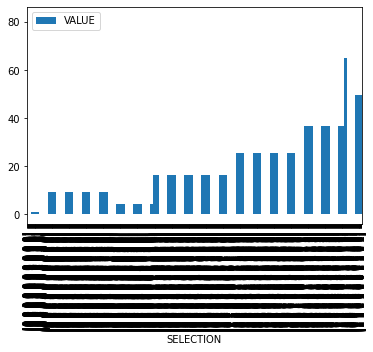

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'C:\Users\shrey\Documents\stockdata1.2.csv')

df.plot(kind = 'bar', x = 'SELECTION', y = 'VALUE')

plt.show()